# Homework 04
### Implementing Artificial Neural Networks with Tensorflow WS20/21

#### Johanna Linkemeyer, Marisa Wodrich



In this homework we built a model for automatic malaria detection.

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model


# Data Set
Malaria data set containing 27.558 images, half of which are parasitized and half of which are not.

Read the data:

In [3]:
(train_data, test_data), ds_info = tfds.load('malaria', 
                        split=['train[:70%]', 'train[85%:]'], # Only training data available, split this here already to training and testing data
                        as_supervised=True, # This allows to call data, label for train and test data
                        shuffle_files=True, # Shuffle
                        with_info=True # This is only necessary if one wants to load info on the dataset (to variable ds_info)
                        )

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteOMKPG7/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


Print some examples:

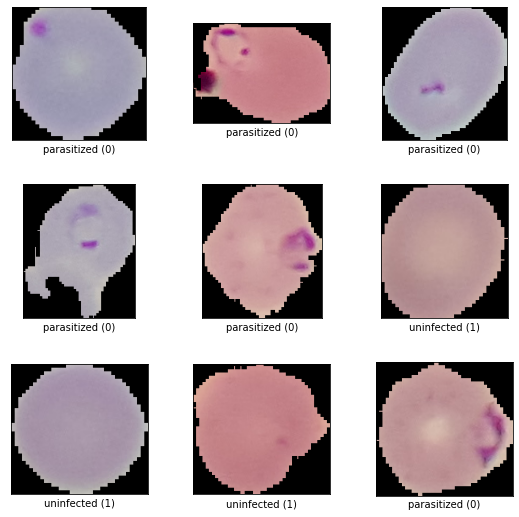

Shape of image 1 : (103, 103, 3)
Shape of image 2 : (103, 103, 3)
Shape of image 3 : (106, 121, 3)
Shape of image 4 : (103, 103, 3)
Shape of image 5 : (115, 157, 3)
Shape of image 6 : (115, 157, 3)
Shape of image 7 : (103, 103, 3)
Shape of image 8 : (103, 103, 3)
Shape of image 9 : (103, 103, 3)
Shape of image 10 : (133, 127, 3)
Shape of image 11 : (115, 157, 3)
Shape of image 12 : (103, 103, 3)
Shape of image 13 : (145, 148, 3)
Shape of image 14 : (103, 103, 3)
Shape of image 15 : (145, 148, 3)
Shape of image 16 : (133, 127, 3)
Shape of image 17 : (103, 103, 3)
Shape of image 18 : (145, 148, 3)
Shape of image 19 : (133, 127, 3)
Shape of image 20 : (103, 103, 3)


In [4]:
fig = tfds.show_examples(train_data, ds_info)

# print the shapes for 20 images
for i in np.arange(1,21):
  for image, _ in train_data.take(1):
    print("Shape of image", i, ":", image.shape)

--> Unfortunatly, the images have different shapes.

Resize the images to quadratic shape:

In [5]:
train_data_preprocessed = train_data.map(lambda x, y: (tf.image.resize_with_crop_or_pad(x, 180, 180), y))
test_data_preprocessed = test_data.map(lambda x, y: (tf.image.resize_with_crop_or_pad(x, 180, 180), y))

Print again and take a look at some shapes. They should all have the same size now.

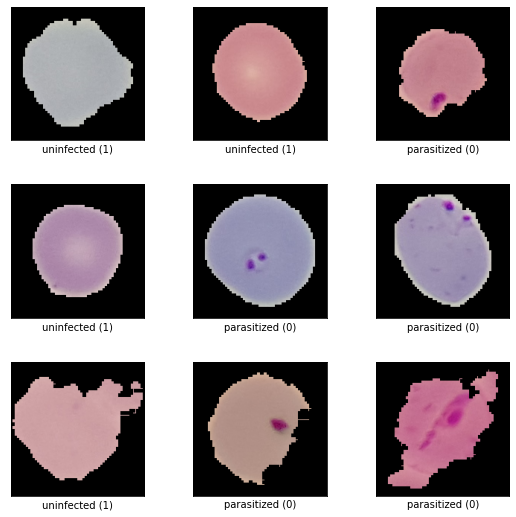

Shape of image 1 : (180, 180, 3)
Shape of image 2 : (180, 180, 3)
Shape of image 3 : (180, 180, 3)
Shape of image 4 : (180, 180, 3)
Shape of image 5 : (180, 180, 3)
Shape of image 6 : (180, 180, 3)
Shape of image 7 : (180, 180, 3)
Shape of image 8 : (180, 180, 3)
Shape of image 9 : (180, 180, 3)
Shape of image 10 : (180, 180, 3)
Shape of image 11 : (180, 180, 3)
Shape of image 12 : (180, 180, 3)
Shape of image 13 : (180, 180, 3)
Shape of image 14 : (180, 180, 3)
Shape of image 15 : (180, 180, 3)
Shape of image 16 : (180, 180, 3)
Shape of image 17 : (180, 180, 3)
Shape of image 18 : (180, 180, 3)
Shape of image 19 : (180, 180, 3)
Shape of image 20 : (180, 180, 3)


In [6]:
fig = tfds.show_examples(train_data_preprocessed, ds_info)

# print the shapes for 20 images
for i in np.arange(1,21):
  for image, _ in train_data_preprocessed.take(1):
    print("Shape of image", i, ":", image.shape)

### Preprocessing

Before building our model, we want to preprocess our data so that our model can actually work well with it. 

In [7]:
# shuffling
d_train = train_data_preprocessed.shuffle(buffer_size=64)
d_test = test_data_preprocessed.shuffle(buffer_size=64)

# Normalize the images so your network can work with them better
d_train = d_train.map(lambda x,y: (tf.image.per_image_standardization(x), y))
d_test = d_test.map(lambda x,y: (tf.image.per_image_standardization(x), y))

# One-hot-encode the labels
d_train = d_train.map(lambda x,y: (x, tf.one_hot(y, 2)))
d_test = d_test.map(lambda x,y: (x, tf.one_hot(y, 2)))

# cast type of tensor
#d_train.map(lambda x,y: (tf.cast(x, tf.bfloat16),y))
#d_test.map(lambda x,y: (tf.cast(x, tf.bfloat16),y))

# change pixel range to [0,1]
d_train = d_train.map(lambda x,y: (x/255, y))
d_test = d_test.map(lambda x,y: (x/255, y))

# batching (minibatches of size 64)
d_train = d_train.batch(64, drop_remainder=True)
d_test = d_test.batch(64, drop_remainder=True)

# prefetch
d_train = d_train.prefetch(buffer_size=2)
d_test = d_test.prefetch(buffer_size=2)

# Model
Convolutional Neural Network to classify the cells from the images in our dataset.

### Define Model

In [8]:
# activation functions
RELU = tf.keras.activations.relu
SOFTMAX = tf.keras.activations.softmax

class Model(Layer):

  def __init__(self):
    """
    INITIALIZING THE MODEL
    structure of our model:
    4 convolutional layers 
    4 max pool layers (one max pool layer after each convolutional layer)
    1 global pool layer
    1 output layer
    """
    super(Model, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=RELU, input_shape=(180,180,3))
    self.max_pool_1 = tf.keras.layers.MaxPool2D()

    self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=RELU, input_shape=(180,180,3))
    self.max_pool_2 = tf.keras.layers.MaxPool2D()

    self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=RELU, input_shape=(180,180,3))
    self.max_pool_3 = tf.keras.layers.MaxPool2D()

    self.conv_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=RELU, input_shape=(180,180,3))
    self.max_pool_4 = tf.keras.layers.MaxPool2D()

    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    
    self.output_layer = tf.keras.layers.Dense(2,activation=SOFTMAX)


  def call(self, x):
    """
    FORWARD STEP
    forward input x through the whole network
    """
    x = self.conv_1(x)
    x = self.max_pool_1(x)
    x = self.conv_2(x)
    x = self.max_pool_2(x)
    x = self.conv_3(x)
    x = self.max_pool_3(x)
    x = self.conv_4(x)
    x = self.max_pool_4(x)
    x = self.global_pool(x)
    x = self.output_layer(x)

    return x

### Train Model

In [9]:
def train_step(model, input, target, loss_function, optimizer):
  """
  performs one training step
  model :         our model
  input :         the input that is fed into the model
  target :        true label of input
  loss_function : our loss function
  optimizer :     our optimizer
  """
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = np.mean(np.argmax(target, axis=1) == np.argmax(prediction, axis=1))
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss, accuracy 


def test(model, test_data, loss_function):
  """
  test model over complete test data set
  model :         our model
  test_data :     our test data
  loss_function : our loss function
  """

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  # iterate over the test data set and predict each label
  # also calculate loss and accuracy 
  for (input, target) in test_data:

    prediction = model(input)
    loss = cross_entropy_loss(target, prediction)
    accuracy = np.sum(np.argmax(target, axis=1) == np.argmax(prediction, axis=1)) / target.shape[0]
    test_accuracy_aggregator.append(accuracy)
    test_loss_aggregator.append(loss)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  


# Training 
Create model instance and define training hyperparameters. Train, train, train!


In [10]:
tf.keras.backend.clear_session()

num_epochs = 25
learning_rate = 0.00005
running_average_factor = 0.95

model = Model()

cross_entropy_loss = tf.keras.losses.binary_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, d_test, cross_entropy_loss)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, d_train, cross_entropy_loss)
#train_losses.append(train_loss)
#train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
  # Track epoch and time while code runs
  start = time.time()
  print('Epoch: __ ' + str(epoch))

  d_train = d_train.shuffle(buffer_size=128)
  d_test = d_test.shuffle(buffer_size=128)

  #training (and checking in with training)
  running_average_loss = 0
  running_average_accuracy = 0

  for (input,target) in d_train:
      train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
      running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
      running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy

  train_losses.append(running_average_loss)
  train_accuracies.append(running_average_accuracy)

  #testing
  test_loss, test_accuracy = test(model, d_test, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # Measure time required for each epoch
  print('... finished after ' + str(time.time() - start) + ' seconds')




Epoch: __ 0
... finished after 58.50541973114014 seconds
Epoch: __ 1
... finished after 70.66872906684875 seconds
Epoch: __ 2
... finished after 72.30105304718018 seconds
Epoch: __ 3
... finished after 71.790522813797 seconds
Epoch: __ 4
... finished after 71.35724687576294 seconds
Epoch: __ 5
... finished after 71.39022302627563 seconds
Epoch: __ 6
... finished after 71.29904413223267 seconds
Epoch: __ 7
... finished after 71.12400197982788 seconds
Epoch: __ 8
... finished after 71.5387237071991 seconds
Epoch: __ 9
... finished after 70.89487409591675 seconds
Epoch: __ 10
... finished after 70.35939311981201 seconds
Epoch: __ 11
... finished after 70.02396988868713 seconds
Epoch: __ 12
... finished after 69.68872499465942 seconds
Epoch: __ 13
... finished after 69.86763453483582 seconds
Epoch: __ 14
... finished after 69.83254742622375 seconds
Epoch: __ 15
... finished after 69.97862124443054 seconds
Epoch: __ 16
... finished after 69.40050101280212 seconds
Epoch: __ 17
... finished a

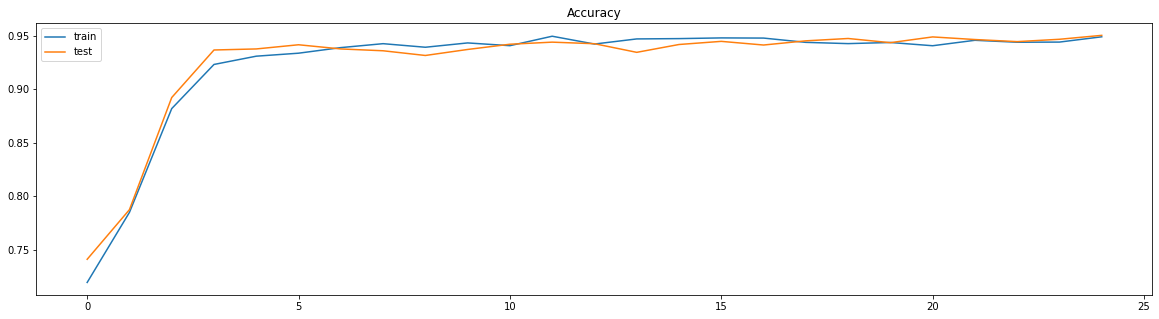

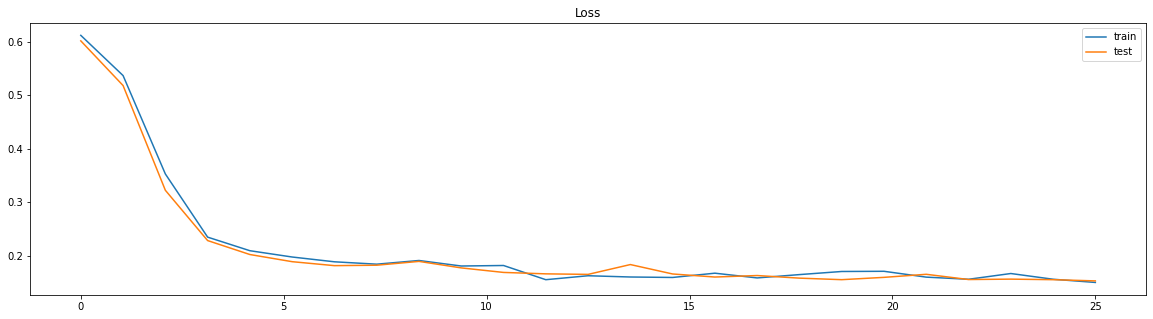

In [14]:
plt.figure(figsize=(20,5))
plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.title("Accuracy")
plt.show()

# for printing we want to reshape our train losses to get a mean for each epoch
# (64 is our batch size)
train_l = np.hstack(train_losses)
train_l = np.mean(train_l.reshape(-1, 64), axis=1)

plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,len(test_losses),len(train_l)), train_l, label="train")
plt.plot(np.linspace(0, len(test_losses), len(test_losses)), test_losses, label="test")
plt.legend()
plt.title("Loss")
plt.show()